---
## `XGBoost model`

By włączyć program należy z poziomu folderu Model_interpretowalny odpalić ".\run_XGBoost.ps1".

---

In [171]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import joblib
import random

from sklearn.calibration import calibration_curve
from sklearn import metrics, set_config
from sklearn.metrics import brier_score_loss, accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer 
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression


set_config(transform_output="pandas")
shap.initjs()

---
## `PKDKodWoEEncoder` (Weight of Evidence Encoder)

Klasa transformująca zmienną kategoryczną 'pkdKod' na miarę Weight of Evidence (WoE). Służy do przygotowania zmiennych kategorycznych o dużej liczbie unikalnych wartości dla modeli scoringowych.

---

### **Działanie Kluczowe**
* Grupowanie Rzadkich Kategorii: Identyfikuje top_n najczęściej występujących kategorii. Wszystkie pozostałe kategorie (rzadkie) są grupowane w jedną kategorię oznaczoną jako '0'.

* Obliczanie WoE: Dla każdej z topowych kategorii i kategorii '0' oblicza WoE. WoE jest logarytmem naturalnym z ilorazu szans (Good/Bad) w danej grupie, podzielonego przez iloraz szans w całej próbie (Good_Total/Bad_Total).

$$WoE = \ln \left( \frac{P(\text{Good} | \text{Grupa})}{P(\text{Bad} | \text{Grupa})} / \frac{P(\text{Good Total})}{P(\text{Bad Total})} \right)$$

* Wygładzanie (Smoothing): Dodaje wartość smoothing (np. 0.5) do liczebności zdarzeń "Good" i "Bad" (dobrych i złych), aby uniknąć dzielenia przez zero i zmniejszyć wpływ małych prób.

* Transformacja: Zastępuje wartość pkdKod obliczoną wartością WoE. Oryginalna kolumna pkdKod jest usuwana.

In [172]:
class PKDKodWoEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=10, smoothing=0.5):
        self.top_n = top_n
        self.smoothing = smoothing
    
    def fit(self, X, y):
        X = X.copy()
        y = y.copy()
        
        self.top_values_ = X['pkdKod'].value_counts().nlargest(self.top_n).index
        
        grouped = X['pkdKod'].where(X['pkdKod'].isin(self.top_values_), other='0')
        
        df = pd.DataFrame({'group': grouped, 'target': y})
        agg = df.groupby('group')['target'].agg(['sum', 'count'])
        agg = agg.rename(columns={'sum':'bad', 'count':'total'})
        agg['good'] = agg['total'] - agg['bad']

        agg['bad_s'] = agg['bad'] + self.smoothing
        agg['good_s'] = agg['good'] + self.smoothing

        total_bad = agg['bad_s'].sum()
        total_good = agg['good_s'].sum()

        agg['woe'] = np.log((agg['good_s'] / total_good) / (agg['bad_s'] / total_bad))

        self.woe_map_ = agg['woe'].to_dict()
        self.fallback_ = agg.loc['0', 'woe'] if '0' in agg.index else np.mean(list(self.woe_map_.values()))
        
        return self
    
    def transform(self, X):
        X = X.copy()
        grouped = X['pkdKod'].where(X['pkdKod'].isin(self.top_values_), other='0')
        X['WoE_pkdKod_grouped'] = grouped.map(self.woe_map_).fillna(self.fallback_)
        return X.drop(columns=['pkdKod'])


---
## `DropConstantColumns` (Usuwanie stałych kolumn)

Prosty transformator, którego zadaniem jest identyfikacja i usunięcie z ramki danych kolumn, które mają **jedną lub zero unikalnych wartości** (są stałe).

---

### **Działanie Kluczowe**

* Fit: W fazie treningu (fit) identyfikuje kolumny, w których liczba unikalnych wartości (nunique()) jest mniejsza lub równa 1. Nazwy tych kolumn są przechowywane w self.cols_to_drop_.
* Transform: W fazie transformacji (transform) usuwa te zidentyfikowane kolumny z ramki danych.

In [173]:
class DropConstantColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.cols_to_drop_ = [col for col in X.columns if X[col].nunique() <= 1]
        return self

    def transform(self, X):
        return X.drop(columns=self.cols_to_drop_, errors='ignore')
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
             raise ValueError("input_features nie może być None dla DropConstantColumns")
        return [col for col in input_features if col not in self.cols_to_drop_]


---
## `MissingValueIndicatorAndImputer`

Ta klasa jest transformatorem scikit-learn, który realizuje dwie operacje jednocześnie na kolumnach numerycznych: imputację brakujących wartości oraz tworzenie kolumn-wskaźników braków danych.

---

### **Działanie Kluczowe**

* Obsługa Nieskończoności: Zamienia wartości nieskończone (np.inf, -np.inf) na braki danych (np.nan).
* Imputacja: Wykorzystuje SimpleImputer (strategia domyślna to mediana, ale można zmienić np. na mean lub most_frequent) do zastąpienia brakujących wartości. W fazie fit uczy się wartości imputacji, a w transform je stosuje.

* Wskaźnik Braków Danych: Tworzy nową kolumnę dla każdej oryginalnej kolumny, której nazwa kończy się na _mial_braki_danych. Wartość w tej kolumnie wynosi 1, jeśli oryginalna kolumna miała brak danych, i 0 w przeciwnym razie.

* Łączenie: Zwraca ramkę danych zawierającą zaimputowane oryginalne kolumny oraz nowo utworzone kolumny-wskaźniki.

In [174]:
class MissingValueIndicatorAndImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy="median"):
        self.strategy = strategy

    def fit(self, X, y=None):
        X = X.replace([np.inf, -np.inf], np.nan).copy()
        self.base_cols_ = list(X.columns)

        self.imputer_ = SimpleImputer(strategy=self.strategy)
        self.imputer_.fit(X[self.base_cols_])

        self.indicator_cols_ = [f"{c}_mial_braki_danych" for c in self.base_cols_]

        return self

    def transform(self, X):
        X = X.replace([np.inf, -np.inf], np.nan).copy()

        X_imputed = pd.DataFrame(
            self.imputer_.transform(X[self.base_cols_]),
            columns=self.base_cols_,
            index=X.index
        )

        indicator_df = X[self.base_cols_].isna().astype(int)
        indicator_df.columns = self.indicator_cols_
        indicator_df.index = X.index

        X_out = pd.concat([X_imputed, indicator_df], axis=1)

        return X_out
    
    def get_feature_names_out(self, input_features=None):
            base_cols = self.base_cols_
            indicator_cols = self.indicator_cols_
            return base_cols + indicator_cols

---
## `Podział Danych na Zbiory` Treningowy, Walidacyjny, Testowy

---

Treningowy (Train): Używany do uczenia modelu.

Walidacyjny (Validation/Val): Używany do strojenia hiperparametrów i wczesnego zatrzymywania treningu (early stopping).

Testowy (Test): Używany do ostatecznej, niezależnej oceny wydajności gotowego modelu.

Użyto dwóch kroków podziału, aby uzyskać proporcje około 70% / 15% / 15% (Train / Val / Test).

In [175]:
# Wczytanie danych
data = pd.read_csv("zbiór_10.csv")

# Definicja cech X i y
X = data.drop(columns=["default"])
y = data["default"]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Train: 2091, Val: 459, Test: 450


---
## `Kodowanie WoE dla Kolumny pkdKod`

---

Ten proces demonstruje kluczową technikę w pre-processingu danych, jaką jest kodowanie Weight of Evidence (WoE), stosowaną na zmiennej kategorycznej pkdKod. Najważniejszą zasadą jest dopasowanie (fit) transformatora wyłącznie do danych treningowych, aby zapewnić, że wiedza o rozkładzie targetu (y) w kategoriach nie wycieknie do zbiorów walidacyjnych i testowych.

In [176]:
print("Fitting WoE Encoder...")
woe_encoder = PKDKodWoEEncoder(top_n=10, smoothing=0.5)

woe_encoder.fit(X_train, y_train)

X_train_woe = woe_encoder.transform(X_train)
X_val_woe = woe_encoder.transform(X_val)
X_test_woe = woe_encoder.transform(X_test)

print("WoE encoding complete.")

Fitting WoE Encoder...
WoE encoding complete.


---
## `Budowa Pipeline'u Preprocessingowego`

---

Poniższy opis definiuje kompleksowy potok (Pipeline) do automatycznego przetwarzania różnych typów cech w zbiorze danych. Użycie ColumnTransformer pozwala na jednoczesne stosowanie różnych transformatorów do cech numerycznych i kategorycznych.

---
### **Definicja Cech**

Po wstępnym kodowaniu WoE kolumny pkdKod, pozostałe kolumny są dzielone na numeryczne i kategoryczne (te, które będą kodowane One-Hot Encodingiem - OHE).

* Cechy Kategoryczne (do OHE): formaWlasnosci_Symbol, schemat_wsk_bilans, schemat_wsk_rzis.

* Cechy Numeryczne: Wszystkie pozostałe kolumny (włączając już przetworzoną cechę WoE).

### **Potok Cech Numerycznych**

Potok dla cech numerycznych jest sekwencją trzech kroków transformacji:

* Imputacja i Wskaźnik Braków (MissingValueIndicatorAndImputer): Wypełnienie brakujących wartości (mediana) oraz utworzenie pomocniczych kolumn binarnych sygnalizujących, gdzie pierwotnie wystąpił brak danych.

* Usunięcie Stałych Kolumn (DropConstantColumns): Identyfikacja i usunięcie cech, które po imputacji (lub z natury) mają jedną lub zero unikalnych wartości.

* Skalowanie (StandardScaler): Standaryzacja pozostałych cech numerycznych (przesunięcie do średniej 0 i skalowanie do odchylenia standardowego 1).

### **Potok Cech Kategorycznych**

Potok ten stosuje One-Hot Encoding (OneHotEncoder) do wcześniej zdefiniowanych cech kategorycznych. Opcja ignorowania nieznanych kategorii (handle_unknown='ignore') jest kluczowa, aby uniknąć błędów, jeśli w zbiorze walidacyjnym lub testowym pojawi się kategoria nieobecna w danych treningowych.

### **ColumnTransformer**

ColumnTransformer łączy oba potoki, stosując je do odpowiednich list cech. Cechy numeryczne trafiają do numeric_transformer, a kategoryczne do categorical_transformer. Opcja remainder='passthrough' jest ustawiona, by zapewnić, że wszystkie kolumny, które nie zostały objęte żadnym z potoków, zostaną włączone do wyjściowego zbioru danych bez zmian.


In [177]:
categorical_features = [
    'formaWlasnosci_Symbol', 
    'schemat_wsk_bilans', 
    'schemat_wsk_rzis'
]

numerical_features = [
    col for col in X_train_woe.columns if col not in categorical_features
]


numeric_transformer = Pipeline(steps=[
    ('missing', MissingValueIndicatorAndImputer(strategy="median")),
    ('drop_constant', DropConstantColumns()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

---
## `Automatyczne wykrywanie kierunku wpływu cech (Constraints)`

---

1. Musimy przepuścić dane przez preprocessor, żeby mieć te same kolumny co model.
2. Tworzymy DataFrame z przetworzonych danych.
3. Obliczamy korelację każdej cechy z y_train (Default). Używamy korelacji Spearmana, bo wyłapuje monotoniczność lepiej niż Pearson.
4. Pomijamy kolumny kategoryczne.

In [178]:
print("Rozpoczynam automatyczne wyznaczanie constraints...")

preprocessor.fit(X_train_woe, y_train)

feature_names = preprocessor.get_feature_names_out()
print(f"Pobrano {len(feature_names)} finalnych nazw cech po preprocesingu.")

X_train_transformed = preprocessor.transform(X_train_woe)
X_train_trans_df = pd.DataFrame(
    X_train_transformed, 
    columns=feature_names, 
    index=X_train.index
)

correlations = X_train_trans_df.corrwith(y_train, method='spearman')

initial_constraints = {}
known_categorical_cols = categorical_features 

print("\nAnaliza cech pod kątem monotoniczności:")

for col_name, corr_value in correlations.items():
    
    is_categorical = False
    
    if col_name.startswith('cat__'):
        is_categorical = True
        
    if not is_categorical:
        for original_cat in known_categorical_cols:
            if original_cat in col_name:
                is_categorical = True
                break
    
    if is_categorical:
        initial_constraints[col_name] = 0
    else:
        if corr_value > 0:
            initial_constraints[col_name] = 1   # Rosnąca (im więcej tym gorzej)
        elif corr_value < 0:
            initial_constraints[col_name] = -1  # Malejąca (im więcej tym lepiej)
        else:
            initial_constraints[col_name] = 0   # Brak korelacji

final_constraints = {}
for name in feature_names:
    if name in initial_constraints:
        final_constraints[name] = initial_constraints[name]
    else:
        final_constraints[name] = 0 
        
constraints = {k: v for k, v in initial_constraints.items() if k in feature_names}


print(f"Wygenerowano ograniczenia dla {len(initial_constraints)} cech, po filtracji pozostawiono {len(constraints)}.")

Rozpoczynam automatyczne wyznaczanie constraints...
Pobrano 248 finalnych nazw cech po preprocesingu.

Analiza cech pod kątem monotoniczności:
Wygenerowano ograniczenia dla 248 cech, po filtracji pozostawiono 248.


---
## `Finalny Potok Modelowania z XGBoost`

---

Ten kod definiuje kompletny potok modelowania (Pipeline), który integruje wszystkie wcześniej zdefiniowane kroki przetwarzania danych (preprocessor) z modelem XGBoost Classifier. Jest to standardowa i zalecana praktyka w uczeniu maszynowym, która zapewnia, że procesy pre-processingu są stosowane konsekwentnie podczas treningu, walidacji i testowania.

Obiekt pipeline jest teraz gotowy do dopasowania do danych treningowych (pipeline.fit(X_train, y_train)). Używając tego potoku, zapewniamy, że podczas treningu i predykcji wszystkie dane przechodzą przez identyczną sekwencję transformacji, co jest niezbędne dla rzetelności modelu.

In [179]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=1000,
    learning_rate=0.05,
    eval_metric='auc',
    early_stopping_rounds=50,
    random_state=42,
    # scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(),
    monotone_constraints=constraints
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

---
## `Eksport Wytrenowanego Pipeline'u do Pliku PKL`

---

Po wytrenowaniu modelu, konieczne jest zapisanie całego obiektu pipeline (zawierającego zarówno transformacje, jak i model XGBoost) do pliku. Używamy do tego biblioteki joblib, która jest wydajna przy dużych obiektach, takich jak modele scikit-learn i pipeline'y.

In [ ]:
# # X_val_processed = pipeline['preprocessor'].fit(X_train_woe).transform(X_val_woe)

# # fit_params = {
# #     'model__eval_set': [(X_val_processed, y_val)],
# #     'model__verbose' : 100
# # }


# fit_params = {
#     'model__eval_set': [(X_val_woe, y_val)],
#     'model__verbose' : 100
# }

# pipeline.fit(X_train_woe, y_train, **fit_params)

# joblib.dump(pipeline, 'XGBoost_model_pipeline.pkl')

# print("Pipeline training complete.")
# print("Model was successfully exported to file 'XGBoost_model_pipeline.pkl'.")


# NOWA WERSJA ------------------------------------------------------------------------------------------------


print("Przygotowanie zbioru walidacyjnego dla XGBoost...")

X_val_transformed_np = preprocessor.transform(X_val_woe)

feature_names = preprocessor.get_feature_names_out()

X_val_processed_df = pd.DataFrame(
    X_val_transformed_np, 
    columns=feature_names, 
    index=X_val_woe.index
)

fit_params = {
    'model__eval_set': [(X_val_processed_df, y_val)],
    'model__verbose': 100
}

print("Rozpoczynam trening modelu...")
pipeline.fit(X_train_woe, y_train, **fit_params)

joblib.dump(pipeline, 'XGBoost_model_pipeline.pkl')

print("Pipeline training complete.")
print("Model was successfully exported to file 'XGBoost_model_pipeline.pkl'.")

Przygotowanie zbioru walidacyjnego dla XGBoost...
Rozpoczynam trening modelu...
[0]	validation_0-auc:0.72792
[94]	validation_0-auc:0.76210
Pipeline training complete.
Model was successfully exported to file 'XGBoost_model_pipeline.pkl'.


---
## `Przygotowanie Danych do Analizy SHAP`

---

Poniższy kod służy do przygotowania przekształconych danych testowych do późniejszej analizy, np. za pomocą biblioteki SHAP (SHapley Additive exPlanations), która pomaga w interpretacji wyników modelu uczenia maszynowego.

* Najpierw kod wydobywa dwa kluczowe elementy ze zdefiniowanego wcześniej obiektu pipeline. 
* Kod próbuje pobrać nazwy cech po ich przekształceniu przez preprocesor. Jest to kluczowe dla interpretowalności, ponieważ przekształcone cechy mogą mieć inne nazwy niż oryginalne.
* Następnie dane testowe X_test_woe są poddawane końcowej transformacji przez wyodrębniony preprocesor.
* Przekształcone dane w postaci tablicy NumPy są konwertowane z powrotem na DataFrame biblioteki pandas, co jest wygodne do dalszej analizy i interpretacji.

In [181]:
preprocessor = pipeline.named_steps['preprocessor']
model = pipeline.named_steps['model']

try:
    final_feature_names = preprocessor.get_feature_names_out()
    print(f"Pobrano {len(final_feature_names)} finalnych nazw cech.")
except Exception as e:
    print(f"Błąd przy get_feature_names_out: {e}")

X_test_transformed_np = preprocessor.transform(X_test_woe)

X_test_transformed_df = pd.DataFrame(
    X_test_transformed_np, 
    columns=final_feature_names, 
    index=X_test_woe.index
)

print("Dane dla SHAP przygotowane.")

Pobrano 248 finalnych nazw cech.
Dane dla SHAP przygotowane.


---
## `Obliczanie Wartości SHAP i Ustalanie Wartości Bazowej`

---

Poniższy kod służy do przygotowania przekształconych danych testowych do późniejszej analizy, np. za pomocą biblioteki SHAP (SHapley Additive exPlanations), która pomaga w interpretacji wyników modelu uczenia maszynowego.

* Inicjalizowany jest obiekt shap.TreeExplainer, który jest zoptymalizowany do interpretacji modeli bazujących na drzewach decyzyjnych.
* Następuje obliczenie wartości SHAP dla całego zbioru danych testowych X_test_transformed_df.
* Ostatecznie drukowana jest Wartość Bazowa, która jest wartością log-odds średniej przewidywanej przez model. Reprezentuje ona wynik modelu, gdybyśmy nie znali żadnych cech dla danej instancji.

In [182]:
explainer = shap.TreeExplainer(model)

print("Obliczanie wartości SHAP...")
shap_values_all_classes = explainer(X_test_transformed_df)
print("Wartości SHAP obliczone.")

shap_values = shap_values_all_classes
baseline = float(shap_values_all_classes.base_values[0])

print(f"Baseline (wartość bazowa log-odds): {baseline:.4f}")

Obliczanie wartości SHAP...
Wartości SHAP obliczone.
Baseline (wartość bazowa log-odds): -2.8324


---
## `Weryfikacja Spójności Analizy SHAP`

---

Ten kod służy do przeprowadzenia weryfikacji i sprawdzenia, czy obliczone wartości SHAP są spójne z surową predykcją modelu dla konkretnej, pojedynczej obserwacji.

* Wybrana zostaje pierwsza obserwacja.
* Model dokonuje surowej predykcji dla tej jednej obserwacji.
* Zgodnie z teorią SHAP, suma wartości bazowej i wszystkich wartości SHAP dla danej obserwacji musi być równa surowej predykcji modelu dla tej obserwacji:
$$\text{Baseline} + \sum (\text{Wartości SHAP}) \approx \text{Surowa Predykcja (log-odds)}$$

In [183]:
idx = 0
obserwacja_idx = X_test_transformed_df.index[idx]
przetworzone_dane_obs = X_test_transformed_df.iloc[[idx]]

shap_sum = float(shap_values.values[idx].sum())

raw_prediction = model.predict(przetworzone_dane_obs, output_margin=True)[0]

print("\nWeryfikacja dla pierwszej obserwacji testowej:")
print("=" * 60)
print(f"Baseline (wartość bazowa):         {baseline:.4f}")
print(f"Suma wartości SHAP:                {shap_sum:+.4f}")
print(f"Baseline + Suma SHAP:              {baseline + shap_sum:.4f}")
print(f"Surowa predykcja modelu (log-odds): {raw_prediction:.4f}")

if abs((baseline + shap_sum) - raw_prediction) < 1e-5:
    print("\nWeryfikacja: Wyjaśnienia są spójne z modelem.")
else:
    print("\nWeryfikacja: Wyjaśnienia NIE są spójne z modelem.")


Weryfikacja dla pierwszej obserwacji testowej:
Baseline (wartość bazowa):         -2.8324
Suma wartości SHAP:                -0.4506
Baseline + Suma SHAP:              -3.2830
Surowa predykcja modelu (log-odds): -3.2830

Weryfikacja: Wyjaśnienia są spójne z modelem.


---
## `Globalna Ważność Cech (Wykres Beeswarm)`

---

Wykres ten dostarcza globalnego podsumowania wyników interpretacji modelu.

* Wizualizacja: Na wykresie każda kropka reprezentuje pojedynczą obserwację i jej wpływ SHAP dla danej cechy.

* Pozycja: Odległość kropki od środka (wartości SHAP równej zero) wskazuje na wielkość wpływu cechy na predykcję.

* Kolor: Kolor kropki najczęściej wskazuje na wartość cechy (np. czerwony = wysoka wartość cechy, niebieski = niska wartość cechy).

W efekcie, wykres ten nie tylko pokazuje, które cechy są najważniejsze (znajdują się na szczycie listy), ale także kierunek i rozrzut ich wpływu na predykcję (pozytywny czy negatywny) w całym zbiorze testowym.

Globalna ważność cech (Beeswarm):


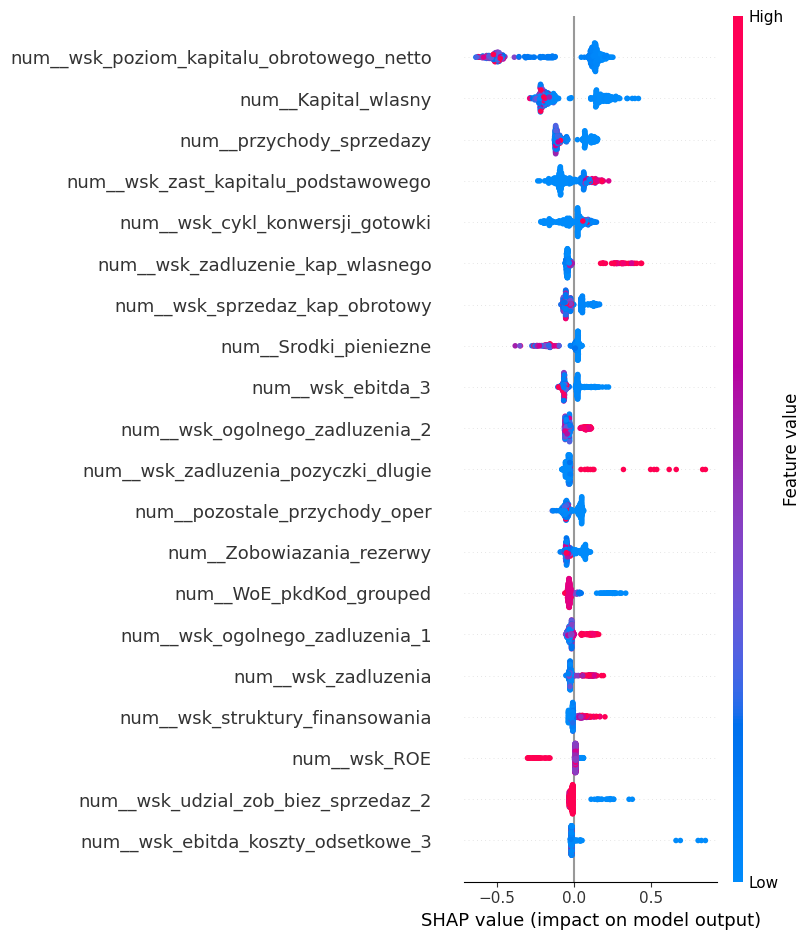

In [184]:
print("Globalna ważność cech (Beeswarm):")

shap.summary_plot(shap_values, X_test_transformed_df)

---
## `Wykres Zależności SHAP (Dependence Plot)`

---

Te bloki kodu służą do wizualizacji konkretnego wpływu pojedynczych cech na predykcję modelu oraz identyfikację potencjalnej interakcji tych cech z innymi. Wybrano do tego 5 najbardziej wpływowych cech:

* num__wsk_poziom_kapitalu_obrotowego_netto

* num__Kapital_wlasny

* num__zysk_netto

* num__wsk_cykl_konwersji_gotowki

* num__wsk_sprzedaz_kap_obrotowy


Wykres zależności dla: num__wsk_poziom_kapitalu_obrotowego_netto


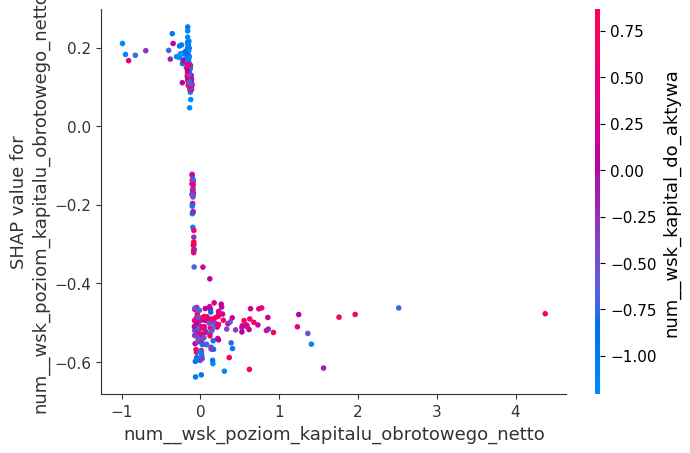

In [185]:
CECHA = 'num__wsk_poziom_kapitalu_obrotowego_netto'

print(f"Wykres zależności dla: {CECHA}")

shap.dependence_plot(
    CECHA,
    shap_values.values,
    X_test_transformed_df,
    interaction_index="auto"
)

Wykres zależności dla: num__Kapital_wlasny


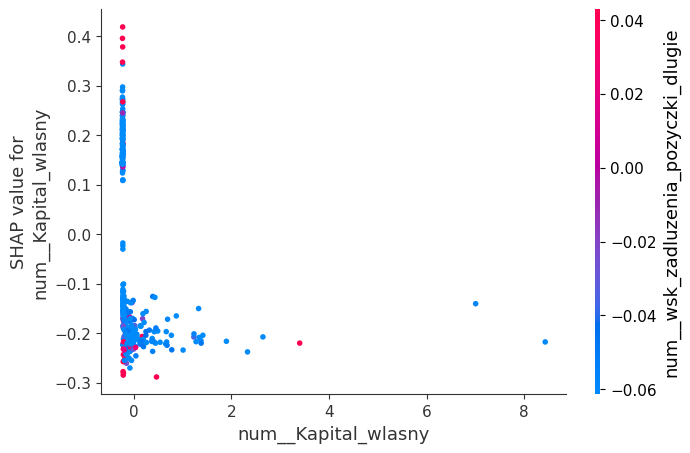

In [186]:
CECHA = 'num__Kapital_wlasny'

print(f"Wykres zależności dla: {CECHA}")

shap.dependence_plot(
    CECHA,
    shap_values.values,
    X_test_transformed_df,
    interaction_index="auto"
)

Wykres zależności dla: num__zysk_netto


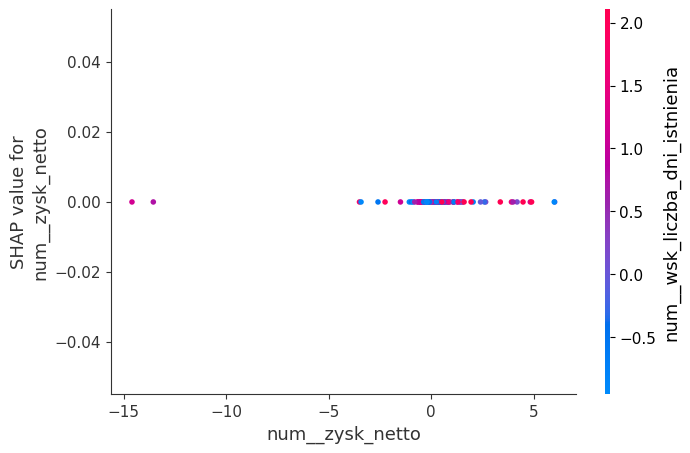

In [187]:
CECHA = 'num__zysk_netto'

print(f"Wykres zależności dla: {CECHA}")

shap.dependence_plot(
    CECHA,
    shap_values.values,
    X_test_transformed_df,
    interaction_index="auto"
)

Wykres zależności dla: num__wsk_cykl_konwersji_gotowki


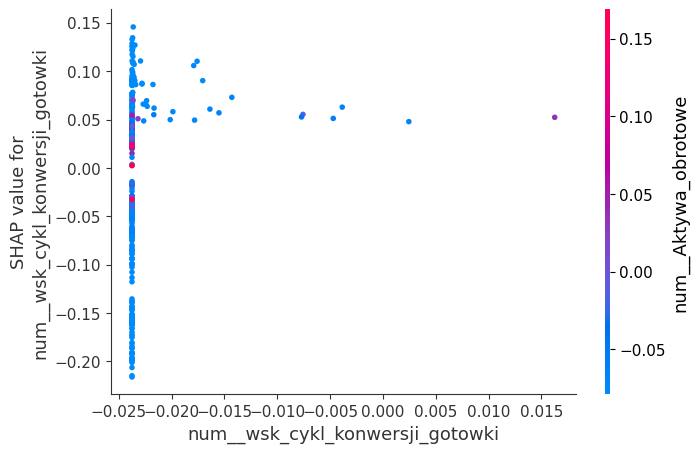

In [188]:
CECHA = 'num__wsk_cykl_konwersji_gotowki'

print(f"Wykres zależności dla: {CECHA}")

shap.dependence_plot(
    CECHA,
    shap_values.values,
    X_test_transformed_df,
    interaction_index="auto"
)

Wykres zależności dla: num__wsk_sprzedaz_kap_obrotowy


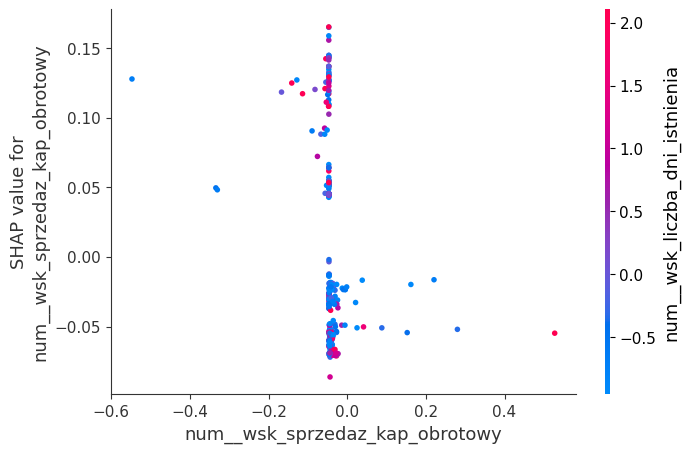

In [189]:
CECHA = 'num__wsk_sprzedaz_kap_obrotowy'

print(f"Wykres zależności dla: {CECHA}")

shap.dependence_plot(
    CECHA,
    shap_values.values,
    X_test_transformed_df,
    interaction_index="auto"
)

---
## `Optymalizacja Progu Decyzyjnego i Ocena Modelu`

---

Tutaj koncentrujemy się na znalezieniu optymalnego progu decyzyjnego dla modelu klasyfikacji binarnej, a następnie na dokładnej ocenie modelu przy użyciu tego nowego progu.

* Prawdopodobieństwa: Najpierw pobierane są prawdopodobieństwa przynależności do y_proba z wytrenowanego pipeline.

* Krzywa Precision-Recall: Obliczane są precision i recall dla różnych możliwych progów decyzyjnych.

* Wykres: Generowany jest wykres zależności precision i recall od progu, co wizualnie pomaga zrozumieć kompromis między tymi metrykami.

* Wybór Optymalnego Progu: Optymalny próg jest wybierany na podstawie maksymalizacji miary F1-Score (średnia harmoniczna precision i recall), co zazwyczaj zapewnia najlepszą równowagę między błędami typu I i II.

* Predykcja: Na podstawie znalezionego best_threshold generowane są ostateczne predykcje binarne (y_pred_best).

* Metryki Modelu: Wyświetlana jest Dokładność (Accuracy) osiągnięta przy nowym progu oraz najlepsze parametry (numer iteracji, wynik walidacji) z samego procesu trenowania modelu.

* Classification Report: Wyświetlany jest szczegółowy raport klasyfikacji, zawierający Precyzję, Czułość i F1-Score dla każdej klasy (No Default i Default).

* Confusion Matrix: Obliczana i drukowana jest macierz pomyłek, która pokazuje True Positives/Negatives, False Positives/Negatives.

* Wizualizacja Macierzy: Macierz pomyłek jest wizualizowana jako mapa ciepła (heatmap).

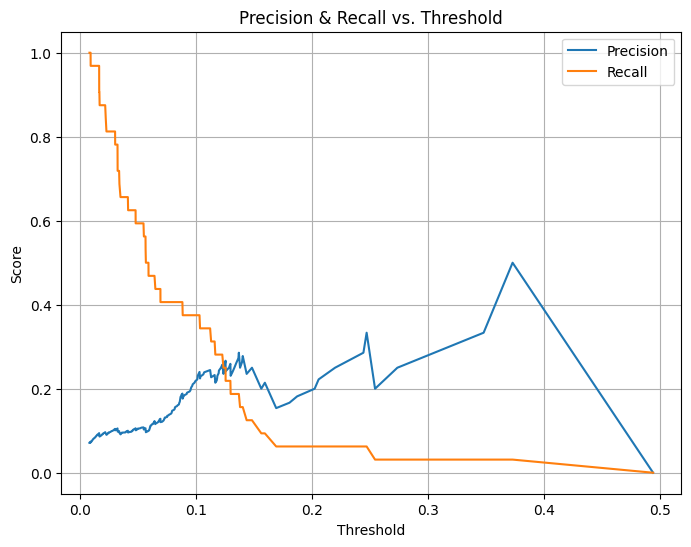


--- Optimal Threshold Finder ---
Best F1-Score: 0.2927
Found at Threshold: 0.1032

--- Model Evaluation ---
Test Accuracy: 0.8711
Best Iteration: 45
Best Score (Validation AUC): 0.7669

--- Classification Report (Threshold = 0.1032) ---
                precision    recall  f1-score   support

No Default (0)       0.95      0.91      0.93       418
   Default (1)       0.24      0.38      0.29        32

      accuracy                           0.87       450
     macro avg       0.59      0.64      0.61       450
  weighted avg       0.90      0.87      0.88       450

--- Confusion Matrix (Threshold = {best_threshold:.4f}) ---
[[380  38]
 [ 20  12]]


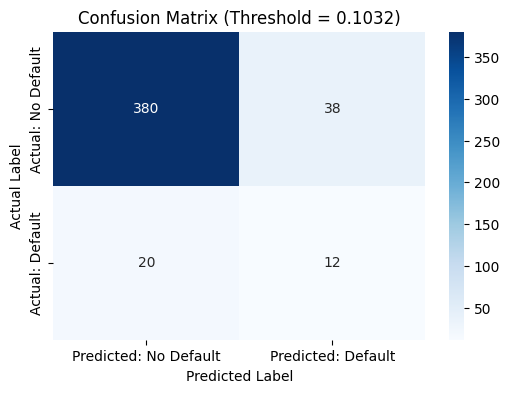

In [190]:
y_proba = pipeline.predict_proba(X_test_woe)[:, 1]

# -----------------------

precision, recall, thresholds = precision_recall_curve(y_test, y_proba, pos_label=1)

# -----------------------


plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs. Threshold')
plt.legend()
plt.grid()
plt.show()

# -----------------------

f1_scores = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)

best_f1_index = np.argmax(f1_scores)

best_threshold = thresholds[best_f1_index]
best_f1_score = f1_scores[best_f1_index]

print(f"\n--- Optimal Threshold Finder ---")
print(f"Best F1-Score: {best_f1_score:.4f}")
print(f"Found at Threshold: {best_threshold:.4f}")

# -----------------------

y_pred_best = (y_proba >= best_threshold).astype(int)

# -----------------------

accuracy = accuracy_score(y_test, y_pred_best)
print(f"\n--- Model Evaluation ---")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Best Iteration: {pipeline.named_steps['model'].best_iteration}")
print(f"Best Score (Validation AUC): {pipeline.named_steps['model'].best_score:.4f}")

# -----------------------

print(f"\n--- Classification Report (Threshold = {best_threshold:.4f}) ---")
print(classification_report(y_test, y_pred_best, target_names=['No Default (0)', 'Default (1)']))

# -----------------------

print("--- Confusion Matrix (Threshold = {best_threshold:.4f}) ---")
cm = confusion_matrix(y_test, y_pred_best)
print(cm)

# -----------------------

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted: No Default', 'Predicted: Default'], 
            yticklabels=['Actual: No Default', 'Actual: Default'])
plt.title(f'Confusion Matrix (Threshold = {best_threshold:.4f})')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
plt.show()

---
## `Analiza Przypadku False Negative`

---

Ten kod ma na celu wyjaśnienie najgroźniejszego rodzaju błędu modelu w klasyfikacji ryzyka: False Negative (FN). FN to klienci, którzy w rzeczywistości ogłosili niewypłacalność (Actual = 1), ale model błędnie przewidział, że są bezpieczni (Predicted = 0).

Wykres wizualnie pokazuje cechy o dodatnim wpływie pchające predykcję w górę i cechy o ujemnym wpływie pchające predykcję w dół.


--- Wyjaśnienie dla obserwacji FALSE NEGATIVE (Indeks: 67) ---


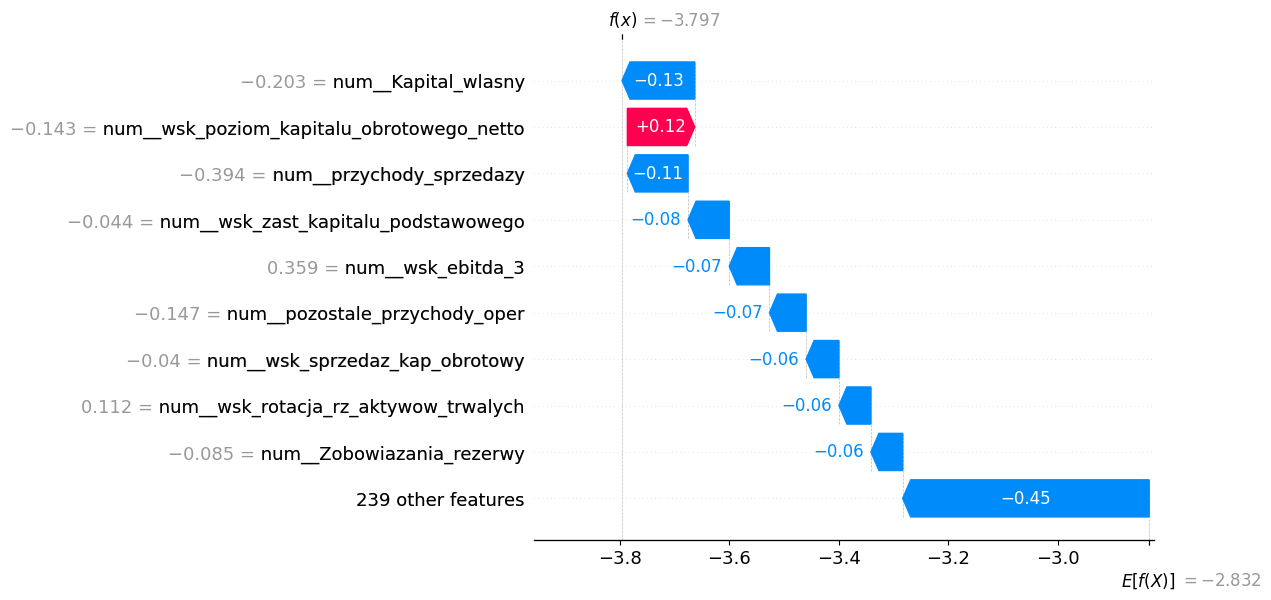


--- Wyjaśnienie dla obserwacji FALSE NEGATIVE (Indeks: 56) ---


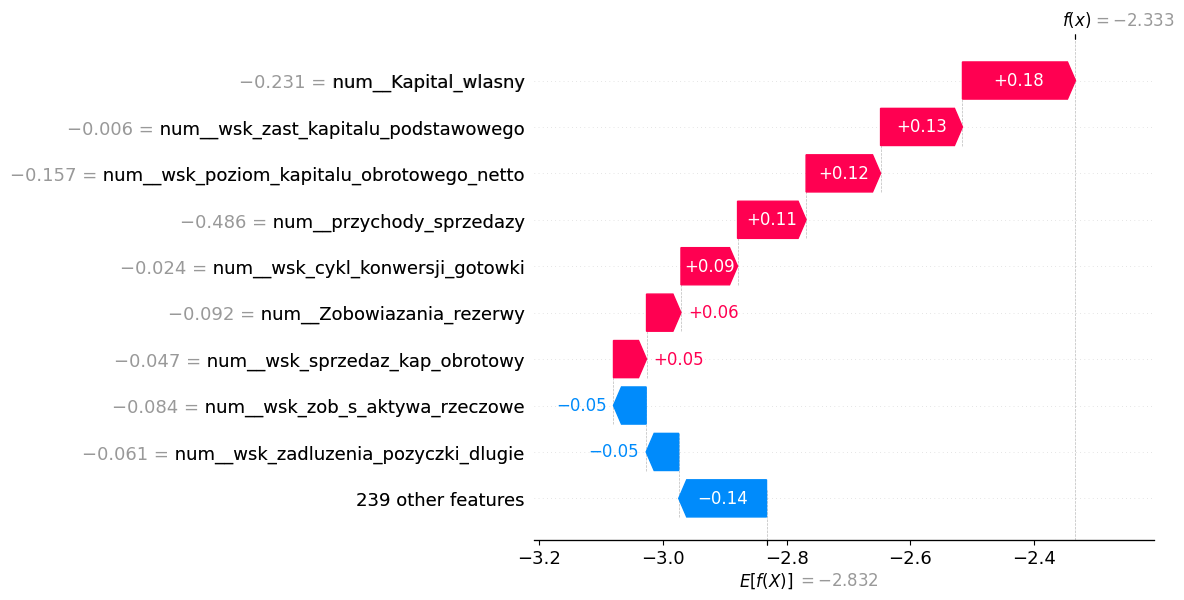


--- Wyjaśnienie dla obserwacji FALSE NEGATIVE (Indeks: 175) ---


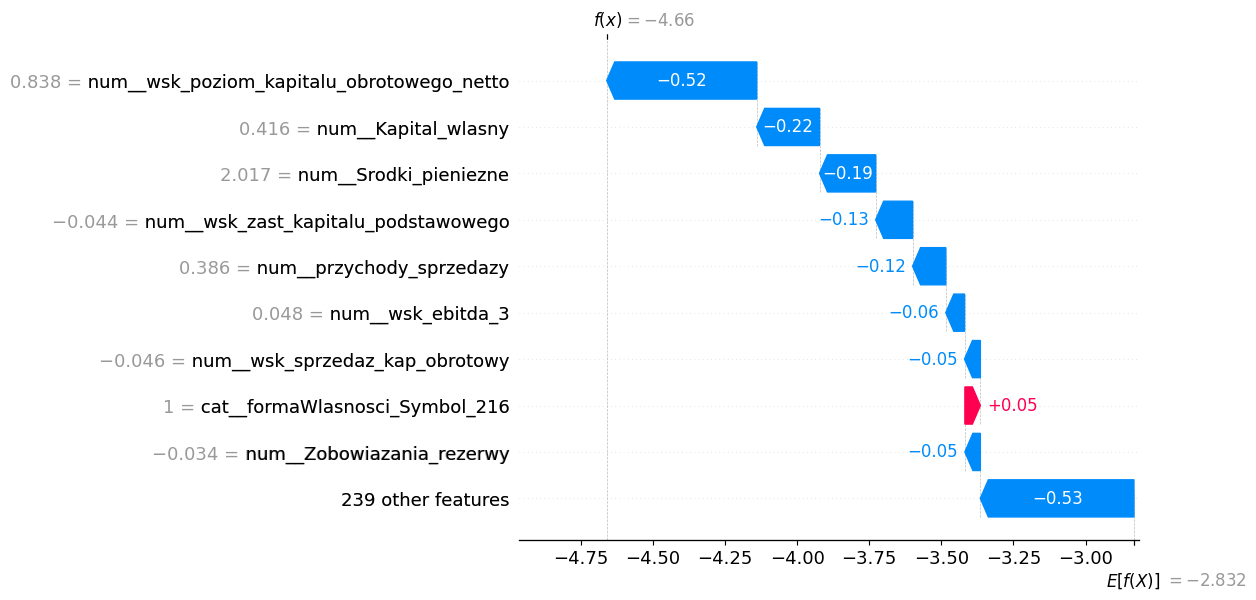

In [191]:
fn_indices = X_test_woe[(y_pred_best == 0) & (y_test == 1)].index

if not fn_indices.empty:

    num_to_check = min(3, len(fn_indices))

    positions_to_check = random.sample(range(len(fn_indices)), num_to_check)

    for i in positions_to_check:
    
        idx_to_explain = fn_indices[i] 
        
        idx_position = X_test_transformed_df.index.get_loc(idx_to_explain)

        print(f"\n--- Wyjaśnienie dla obserwacji FALSE NEGATIVE (Indeks: {idx_to_explain}) ---")
        
        shap.plots.waterfall(shap_values[idx_position])
    
else:
    print("Gratulacje, brak pomyłek False Negative do analizy.")

---
## `Analiza Cech Właściwych dla Błędów False Negative`

---

Ten kod ma na celu izolację i wizualizację statystycznego wpływu cech wyłącznie dla grupy obserwacji sklasyfikowanych jako False Negative (FN). Pokazuje, dlaczego ten konkretny podzbiór klientów, mimo że w rzeczywistości ryzykowny, został uznany przez model za bezpieczny.

Analizuję 20 przypadków False Negative...
Generuję wykres 'summary_plot' tylko dla przypadków FN:


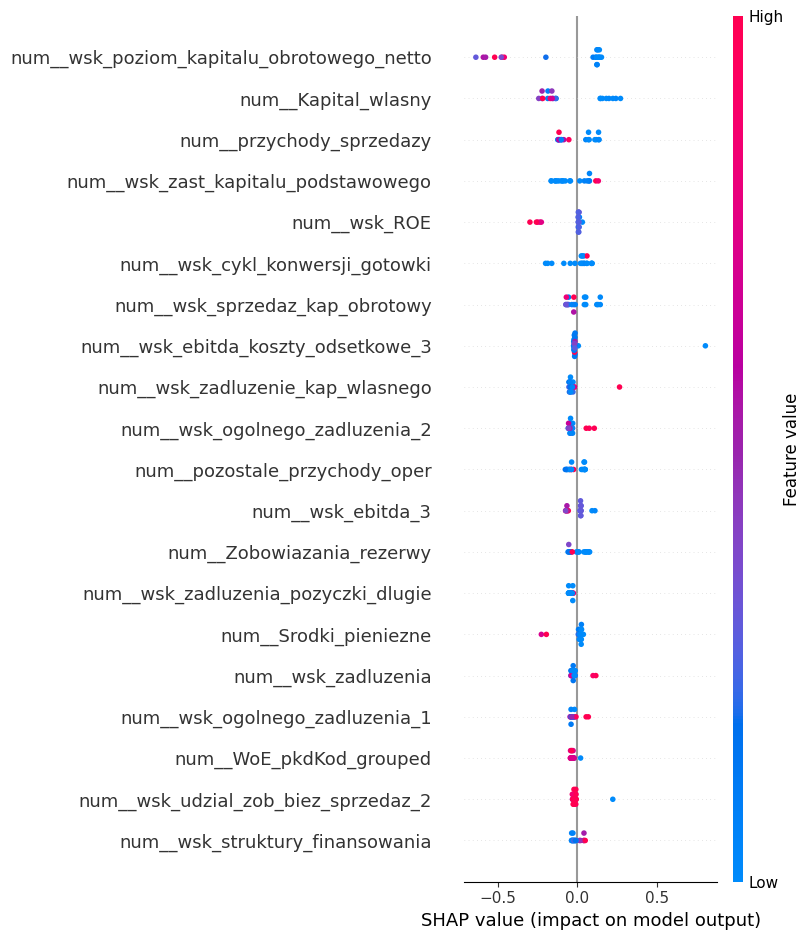

In [192]:
fn_indices = X_test_woe[(y_pred_best == 0) & (y_test == 1)].index

if not fn_indices.empty:
    print(f"Analizuję {len(fn_indices)} przypadków False Negative...")
    
    fn_positions = X_test_transformed_df.index.get_indexer(fn_indices)
    
    fn_positions = fn_positions[fn_positions != -1]

    print("Generuję wykres 'summary_plot' tylko dla przypadków FN:")
    
    shap.summary_plot(
        shap_values[fn_positions], 
        X_test_transformed_df.iloc[fn_positions]
    )
    
else:
    print("Brak pomyłek False Negative do analizy.")

---
## `Analiza Kalibracji Modelu`

---

1. expected_calibration_error: oblicza Błąd Oczekiwanej Kalibracji (ECE) dla modelu klasyfikacji.

2. reliability_plot: generuje Wykres Wiarygodności (Reliability Plot), zwany też krzywą kalibracji.

3. hist_predictions: generuje histogram prognozowanych prawdopodobieństw.


---  DIAGNOSTYKA MODELU (PRE-CALIBRATION) ---


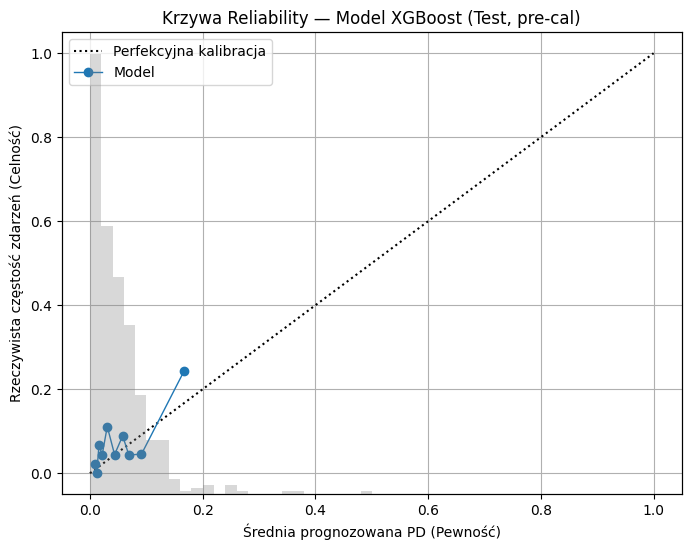

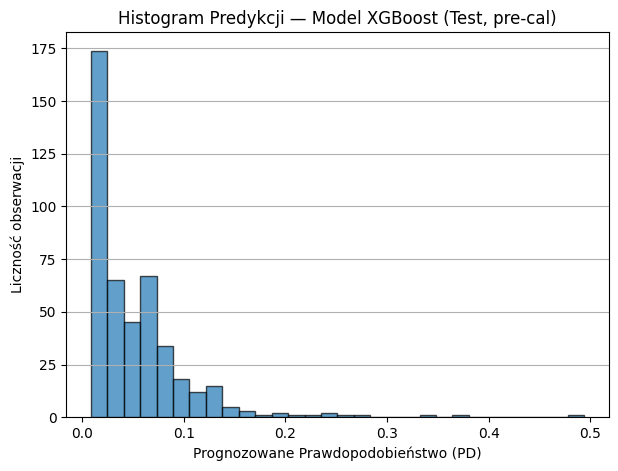


Wyniki (pre-cal):
  Oczekiwany Błąd Kalibracji (ECE): 0.0243
  Wynik Briera (Brier Score):       0.0644


In [193]:
def expected_calibration_error(y_true, p, n_bins=10):
    y_true = np.array(y_true)
    p = np.array(p)
    
    if p.ndim > 1:
        p = p.ravel()
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        mask = (p >= bins[i]) & (p < bins[i+1])
        if mask.any():
            conf = p[mask].mean()
            acc = y_true[mask].mean()
            ece += (mask.sum()/len(p)) * abs(acc - conf)
    return ece

# def reliability_plot(y_true, p, title):

#     frac_pos, mean_pred = calibration_curve(y_true, p, n_bins=10, strategy='uniform')
    
#     plt.figure(figsize=(7, 6))
#     plt.plot([0,1],[0,1], '--', label='Perfekcyjna kalibracja')
#     plt.plot(mean_pred, frac_pos, marker='o', label='Model XGBoost')
#     plt.title(title)
#     plt.xlabel("Średnia prognozowana PD (Pewność)")
#     plt.ylabel("Rzeczywista częstość zdarzeń (Celność)")
#     plt.legend()
#     plt.grid(True)
#     plt.show()


# NOWA WERSJA -----------------------------------------------------------------------------------------------------


def reliability_plot(y_true, p, title):
    frac_pos, mean_pred = calibration_curve(y_true, p, n_bins=10, strategy='quantile')
    
    plt.figure(figsize=(8, 6))
    
    plt.plot([0, 1], [0, 1], 'k:', label='Perfekcyjna kalibracja')
    
    plt.plot(mean_pred, frac_pos, marker='o', linewidth=1, label='Model')
    
    ax = plt.gca()
    ax2 = ax.twinx()
    ax2.hist(p, bins=50, range=(0,1), alpha=0.3, color='gray', label='Rozkład predykcji')
    ax2.set_yticks([]) # Ukrywamy liczby histogramu, żeby nie zaciemniać
    
    plt.title(title)
    ax.set_xlabel("Średnia prognozowana PD (Pewność)")
    ax.set_ylabel("Rzeczywista częstość zdarzeń (Celność)")
        
    ax.legend(loc='upper left')
    ax.grid(True)
    plt.show()
    
def hist_predictions(p, title):

    plt.figure(figsize=(7, 5))
    plt.hist(p, bins=30, edgecolor='k', alpha=0.7)
    plt.title(title)
    plt.xlabel("Prognozowane Prawdopodobieństwo (PD)")
    plt.ylabel("Liczność obserwacji")
    plt.grid(axis='y')
    plt.show()


print("---  DIAGNOSTYKA MODELU (PRE-CALIBRATION) ---")

reliability_plot(y_test, y_proba, "Krzywa Reliability — Model XGBoost (Test, pre-cal)")

hist_predictions(y_proba, "Histogram Predykcji — Model XGBoost (Test, pre-cal)")

ece_pre = expected_calibration_error(y_test, y_proba, n_bins=10)
brier_pre = brier_score_loss(y_test, y_proba)

print(f"\nWyniki (pre-cal):")
print(f"  Oczekiwany Błąd Kalibracji (ECE): {ece_pre:.4f}")
print(f"  Wynik Briera (Brier Score):       {brier_pre:.4f}")

---
## `Funkcje Kalibracji Modelu (Platt i Isotonic)`

---

Poniższy kod definiuje funkcje przeznaczone do kalibracji prognoz prawdopodobieństwa modelu, co jest procesem dostosowywania niekalibrowanych wyjść w celu uzyskania bardziej wiarygodnych i dokładnych prawdopodobieństw. Porównujemy skuteczność metody Platt'a i Izotonicznej.

Obliczanie prognoz dla zbioru walidacyjnego...
Dopasowywanie kalibratorów na zbiorze walidacyjnym...
Kalibratory wytrenowane.
Stosowanie kalibratorów na zbiorze testowym...

--- OCENA (POST-CALIBRATION) ---

--- Model: Platt (post-cal) ---


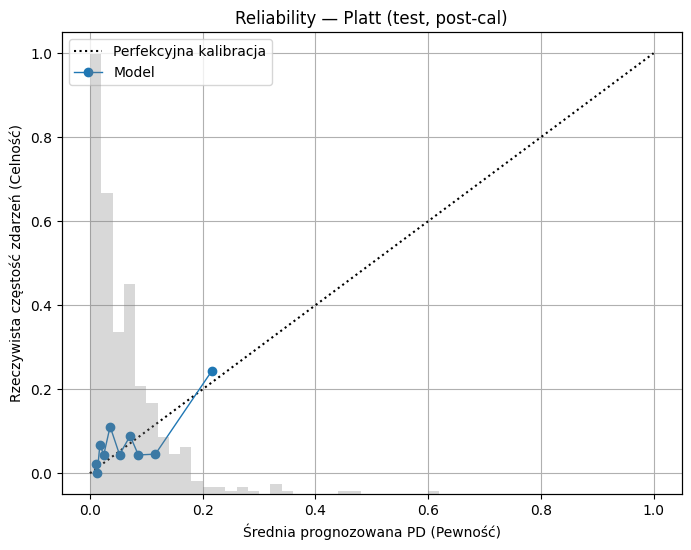

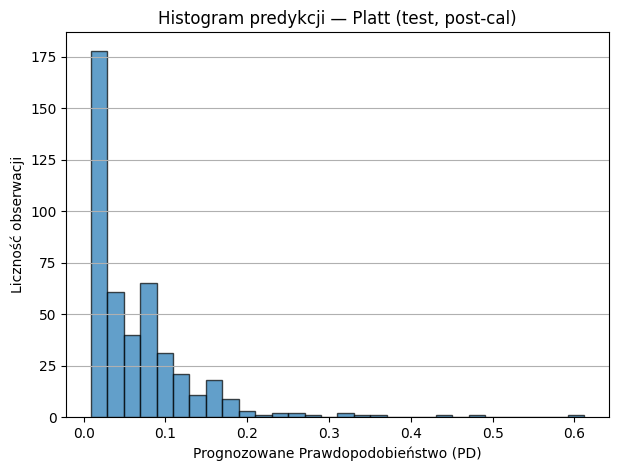

Wyniki dla Platt (post-cal):
  Oczekiwany Błąd Kalibracji (ECE): 0.0154
  Wynik Briera (Brier Score):       0.0645

--- Model: Isotonic (post-cal) ---


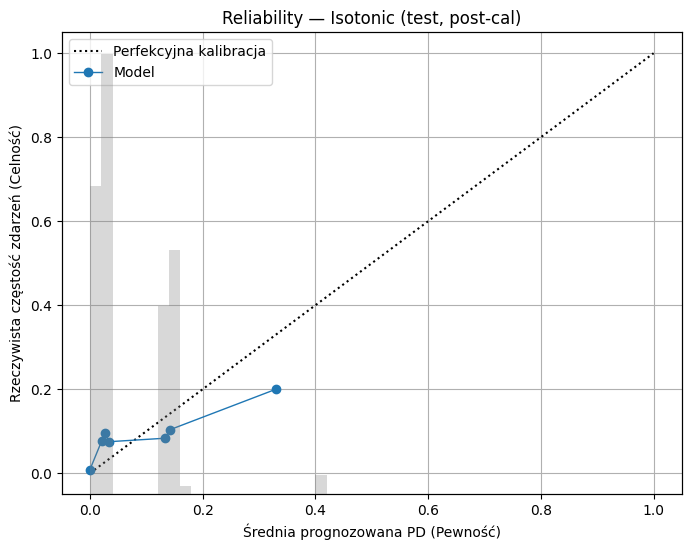

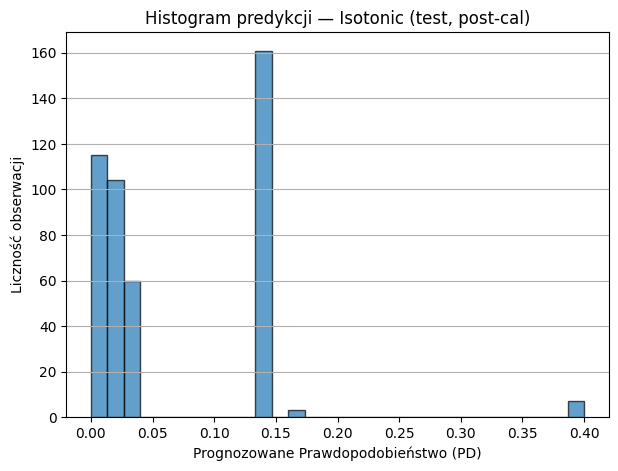

Wyniki dla Isotonic (post-cal):
  Oczekiwany Błąd Kalibracji (ECE): 0.0397
  Wynik Briera (Brier Score):       0.0661


In [194]:
def fit_platt(y, p):
    eps = 1e-12
    logit = np.log(np.clip(p, eps, 1-eps) / np.clip(1-p, eps, 1-eps))
    lr = LogisticRegression(max_iter=500, C=1e6) 
    lr.fit(logit.reshape(-1,1), y)
    return lr

def apply_platt(lr, p):
    eps = 1e-12
    logit = np.log(np.clip(p, eps, 1-eps) / np.clip(1-p, eps, 1-eps))
    return lr.predict_proba(logit.reshape(-1,1))[:,1]

def fit_isotonic(y, p):
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(p, y)
    return ir

def apply_isotonic(ir, p):
    return ir.transform(p)


print("Obliczanie prognoz dla zbioru walidacyjnego...")
y_proba_val = pipeline.predict_proba(X_val_woe)[:, 1]

y_proba_test_pre_cal = y_proba 

print("Dopasowywanie kalibratorów na zbiorze walidacyjnym...")
platt_model = fit_platt(y_val, y_proba_val)
iso_model = fit_isotonic(y_val, y_proba_val)
print("Kalibratory wytrenowane.")

print("Stosowanie kalibratorów na zbiorze testowym...")
y_proba_test_platt = apply_platt(platt_model, y_proba_test_pre_cal)
y_proba_test_iso   = apply_isotonic(iso_model, y_proba_test_pre_cal)

print("\n--- OCENA (POST-CALIBRATION) ---")

calibrated_probas = {
    'Platt': y_proba_test_platt,
    'Isotonic': y_proba_test_iso
}

for name, p in calibrated_probas.items():
    print(f"\n--- Model: {name} (post-cal) ---")
            
    reliability_plot(y_test, p, f"Reliability — {name} (test, post-cal)")
    hist_predictions(p, f"Histogram predykcji — {name} (test, post-cal)")
    
    ece_post = expected_calibration_error(y_test, p, n_bins=10)
    brier_post = brier_score_loss(y_test, p)
    
    print(f"Wyniki dla {name} (post-cal):")
    print(f"  Oczekiwany Błąd Kalibracji (ECE): {ece_post:.4f}")
    print(f"  Wynik Briera (Brier Score):       {brier_post:.4f}")

---
## `Funkcje Transformacji Logit i Dopasowania Średniej`

---

Ten zestaw funkcji służy do zaawansowanej manipulacji prawdopodobieństwami wyjściowymi modelu, wykorzystując skalę log-odds (logit) do precyzyjnego dopasowania średniej prognozowanego ryzyka do z góry określonej docelowej stopy ryzyka.

* logit_fn: konwersja prawdopodobieństwa P na log-odds.

* inv_logit: konwersja log-odds z powrotem na prawdopodobieństwo P.

* shift_to_target_mean: dostosowanie wszystkich prognoz prawdopodobieństwa w taki sposób, aby ich średnia była równa z góry ustalonej wartości target_mean (np. u nas 4% ryzyka).

Średnia prognoza (Isotonic, przed shiftem): 0.0667
Rozpoczynam dostrajanie do średniej = 0.04...

--- OCENA (POST-SHIFT 4%) ---
Średnia po dostrojeniu: 0.0400 (Cel: 0.04)
Brier (post-shift): 0.0657
ECE (post-shift):   0.0325


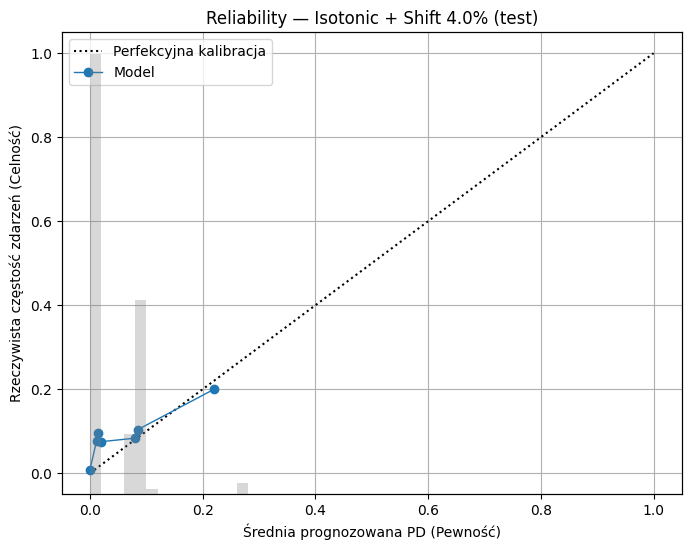

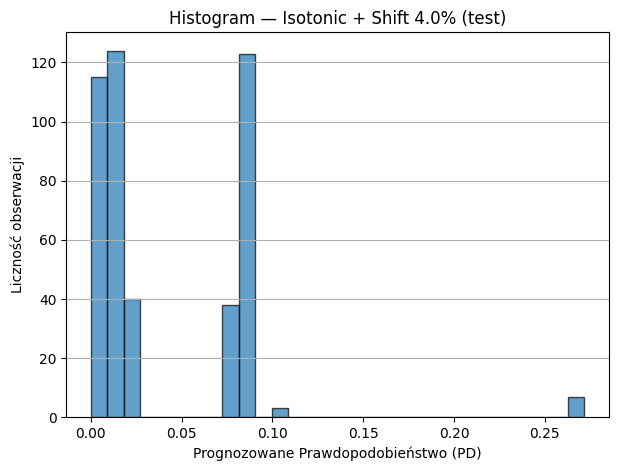


--- Obliczanie Statystyki KS ---
Statystyka KS (Kolmogorov-Smirnov): 0.2415
Próg, przy którym osiągnięto KS: 0.0119


In [195]:
def logit_fn(p, eps=1e-12):
    p = np.clip(p, eps, 1-eps)
    return np.log(p/(1-p))

def inv_logit(z):
    return 1/(1+np.exp(-z))

def shift_to_target_mean(p, target_mean=0.04, tol=1e-6, max_iter=100):
    
    z = logit_fn(p)
    
    lo, hi = -10.0, 10.0
    
    for _ in range(max_iter):
        mid = (lo+hi)/2
        m = inv_logit(z + mid).mean()
        
        if abs(m - target_mean) < tol:
            return inv_logit(z + mid)
        
        if m < target_mean:
            lo = mid
        else:
            hi = mid
    
    print("Ostrzeżenie: Osiągnięto limit iteracji w wyszukiwaniu.")
    return inv_logit(z + (lo+hi)/2)


proba_iso_pre_shift = y_proba_test_iso
proba_iso_pre_shift_arr = np.array(proba_iso_pre_shift).flatten()

print(f"Średnia prognoza (Isotonic, przed shiftem): {proba_iso_pre_shift_arr.mean():.4f}")
# print(f"Średnia prognoza (Isotonic, przed shiftem): {proba_iso_pre_shift.mean():.4f}")

target_pd_mean = 0.04
print(f"Rozpoczynam dostrajanie do średniej = {target_pd_mean}...")
# proba_iso_4pct = shift_to_target_mean(proba_iso_pre_shift, target_mean=target_pd_mean)
proba_iso_4pct = shift_to_target_mean(proba_iso_pre_shift_arr, target_mean=target_pd_mean)

print("\n--- OCENA (POST-SHIFT 4%) ---")
print(f"Średnia po dostrojeniu: {proba_iso_4pct.mean():.4f} (Cel: {target_pd_mean})")

brier_4pct = brier_score_loss(y_test, proba_iso_4pct)
ece_4pct = expected_calibration_error(y_test, proba_iso_4pct)

print(f"Brier (post-shift): {brier_4pct:.4f}")
print(f"ECE (post-shift):   {ece_4pct:.4f}")

reliability_plot(y_test, proba_iso_4pct, f"Reliability — Isotonic + Shift {target_pd_mean*100}% (test)")
hist_predictions(proba_iso_4pct, f"Histogram — Isotonic + Shift {target_pd_mean*100}% (test)")



print("\n--- Obliczanie Statystyki KS ---")

p_data = proba_iso_4pct 
y_true_data = y_test

fpr, tpr, thresholds = metrics.roc_curve(y_true_data, p_data)

ks_statistic = np.max(tpr - fpr)

ks_threshold = thresholds[np.argmax(tpr - fpr)]

print(f"Statystyka KS (Kolmogorov-Smirnov): {ks_statistic:.4f}")
print(f"Próg, przy którym osiągnięto KS: {ks_threshold:.4f}")

---
## `Macierz Kosztów Decyzyjnych`

---

Ten fragment kodu definiuje macierz kosztów dla problemu klasyfikacji binarnej, przypisuje wagę finansową (lub inną miarę straty) do każdego z czterech możliwych wyników predykcji.

In [196]:
COST_TP = 0.0
COST_FP = 1.0
COST_FN = 12
COST_TN = -1.0

---
## `Funkcje Optymalizacji Kosztu Decyzyjnego`

---

Ten blok kodu definiuje dwie funkcje służące do obliczenia całkowitego kosztu podejmowanych decyzji w modelu klasyfikacji w oparciu o zdefiniowaną wcześniej macierz kosztów, a następnie do systematycznego przeszukiwania (sweep) różnych progów decyzyjnych w celu znalezienia progu minimalizującego ten koszt.

In [197]:
def cost_for_threshold(y_true, p, thr):
    yhat = (p >= thr).astype(int)
    
    tp = np.sum((yhat==1) & (y_true==1))
    fp = np.sum((yhat==1) & (y_true==0))
    fn = np.sum((yhat==0) & (y_true==1))
    tn = np.sum((yhat==0) & (y_true==0))
    
    total_cost = tp*COST_TP + fp*COST_FP + fn*COST_FN + tn*COST_TN
    return total_cost, tp, fp, fn, tn

def sweep_costs(y_true, p, n=1001):
    thrs = np.linspace(0,1,n)
    costs, details = [], []
    for t in thrs:
        c, tp, fp, fn, tn = cost_for_threshold(y_true, p, t)
        costs.append(c); details.append((tp,fp,fn,tn))
    return thrs, np.array(costs), details

---
## `Optymalizacja Progu Decyzyjnego w oparciu o Koszty Biznesowe`

---

Poniższy fragment kodu przeprowadza analizę wrażliwości modelu na zmianę progu odcięcia (threshold). Celem jest znalezienie optymalnego punktu pracy, który minimalizuje całkowity koszt finansowy, a nie tylko błąd statystyczny.

Kluczowe kroki analizy:
1.  Sweep (Przeszukiwanie): Obliczenie kosztów dla 201 różnych progów (od 0 do 1).
2.  Optymalizacja: Wybór progu, dla którego funkcja kosztu osiąga minimum:
    $$Cost_{total} = (FP \cdot Cost_{FP}) + (FN \cdot Cost_{FN}) + (TN \cdot Cost_{TN}) + (TP \cdot Cost_{TP})$$
3.  Wizualizacja: Wykres zależności całkowitego kosztu od przyjętego progu decyzyjnego.
4.  Raportowanie: Wyświetlenie szczegółowej macierzy pomyłek oraz stopy akceptacji (Acceptance Rate) dla najlepszego progu.

---

Rozpoczynam analizę zysków i strat dla 450 obserwacji...


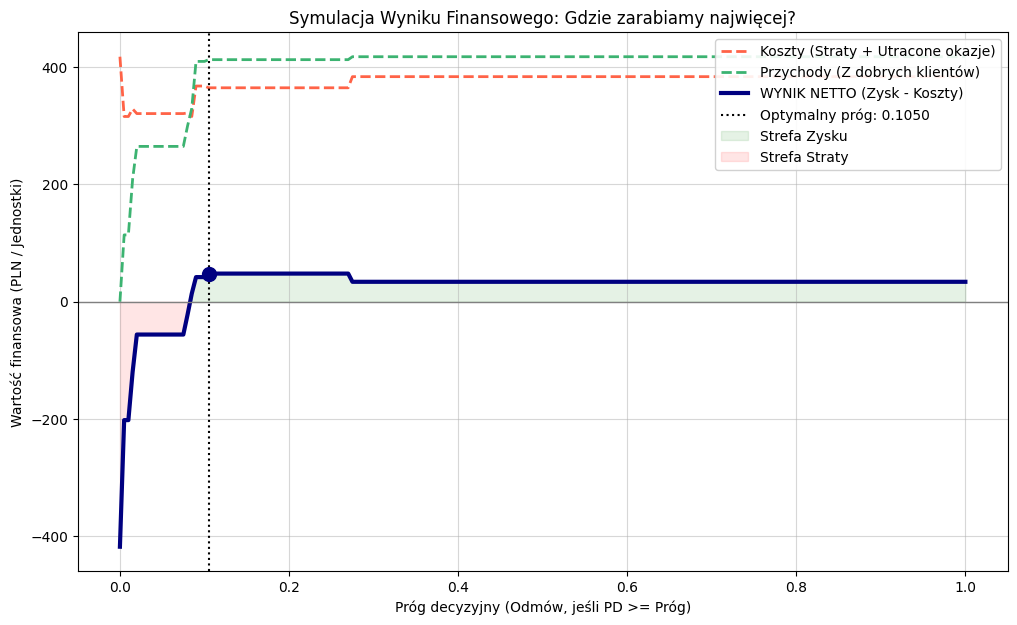


--- WYNIKI SYMULACJI BIZNESOWEJ (Próg: 0.1050) ---
1. Przychody (Revenue):         413.00
2. Koszty (Losses):            -365.00
----------------------------------------
3. ZYSK OPERACYJNY (Profit):    48.00
----------------------------------------
Stopa akceptacji: 98.44%
Macierz pomyłek: TP=2, FP=5, FN=30, TN=413


In [198]:
# y_true_data = y_test
# p_data = proba_iso_4pct 

# print(f"Rozpoczynam analizę kosztów dla {len(p_data)} obserwacji...")

# thrs, costs, details = sweep_costs(y_true_data, p_data, n=201)

# best_idx = int(np.argmin(costs))
# best_thr_cost = float(thrs[best_idx])
# best_cost = costs[best_idx]
# best_tp, best_fp, best_fn, best_tn = details[best_idx]

# plt.figure(figsize=(10, 6))
# plt.plot(thrs, costs, label='Całkowity koszt biznesowy')
# plt.axvline(x=best_thr_cost, color='red', linestyle='--', 
#             label=f'Optymalny próg: {best_thr_cost:.4f}\n(Min. koszt: {best_cost:.2f})')
# plt.title("Krzywa kosztu vs próg decyzyjny")
# plt.xlabel("Próg decyzyjny (Odmów, jeśli PD >= Próg)")
# plt.ylabel("Całkowity koszt (Im niżej, tym lepiej)")
# plt.legend()
# plt.grid(True)
# plt.show()

# print("\n--- Wyniki Optymalnego Progu Biznesowego ---")
# print(f"Optymalny próg (minimalizujący koszt): {best_thr_cost:.4f}")
# print(f"Minimalny osiągnięty koszt: {best_cost:.2f}")
# print("\nMacierz pomyłek dla tego progu:")
# print(f"  Prawdziwie Pozytywni (TP - Odmówiono złym): {best_tp}")
# print(f"  Fałszywie Pozytywni (FP - Odmówiono dobrym): {best_fp}  (Koszt: {best_fp * COST_FP})")
# print(f"  Fałszywie Negatywni (FN - Udzielono złym):  {best_fn}  (Koszt: {best_fn * COST_FN})")
# print(f"  Prawdziwie Negatywni (TN - Udzielono dobrym): {best_tn}  (Zysk: {best_tn * COST_TN})")

# accept_rate = (best_fn + best_tn) / len(y_true_data)
# print(f"\nStopa akceptacji (udzielono kredytu): {accept_rate:.2%}")

# # --- PRZYGOTOWANIE DANYCH ---
# y_true_data = y_test
# p_data = proba_iso_4pct 

# print(f"Rozpoczynam analizę kosztów dla {len(p_data)} obserwacji...")

# # Obliczamy koszty dla wszystkich progów
# thrs, costs, details = sweep_costs(y_true_data, p_data, n=201)

# # Znajdujemy najlepszy próg (minimum całkowitego kosztu)
# best_idx = int(np.argmin(costs))
# best_thr_cost = float(thrs[best_idx])
# best_cost = costs[best_idx]
# best_tp, best_fp, best_fn, best_tn = details[best_idx]

# # --- PRZYGOTOWANIE ROZBICIA NA ZYSKI I STRATY ---

# # Rozpakowujemy listę 'details' do tablic numpy, żeby móc na nich liczyć
# # structure of details: [(tp, fp, fn, tn), ...]
# details_arr = np.array(details)
# fps_arr = details_arr[:, 1]
# fns_arr = details_arr[:, 2]
# tns_arr = details_arr[:, 3]

# # 1. Obliczamy STRATY (Losses) -> To są koszty dodatnie
# # Składa się na nie: Strata na złych (FN * 16) + Utracone okazje (FP * 1)
# losses_vec = (fns_arr * COST_FN) + (fps_arr * COST_FP)

# # 2. Obliczamy ZYSKI (Gains) -> To są koszty ujemne
# # Składa się na nie: Zysk z dobrych klientów (TN * -1)
# # Wynik będzie liczbą ujemną (np. -500), co na wykresie będzie "pod kreską"
# gains_vec = tns_arr * COST_TN

# # --- RYSOWANIE WYKRESU BIZNESOWEGO ---

# plt.figure(figsize=(12, 7))

# # A. Linia całkowitego wyniku (Netto) - To Twój dotychczasowy "koszt"
# plt.plot(thrs, costs, color='blue', linewidth=3, label='WYNIK NETTO (Suma)')

# # B. Linia Strat (Czerwona - nad zerem)
# plt.plot(thrs, losses_vec, color='red', linestyle='--', label='Straty (Kapitał + Utracone okazje)')

# # C. Linia Zysków (Zielona - pod zerem)
# plt.plot(thrs, gains_vec, color='green', linestyle='--', label='Przychody (Zysk z dobrych klientów)')

# # Linie pomocnicze
# plt.axvline(x=best_thr_cost, color='black', linestyle=':', label=f'Optimum: {best_thr_cost:.4f}')
# plt.axhline(y=0, color='gray', linewidth=1) # Linia zero (próg rentowności)

# # Wypełnienie kolorami
# plt.fill_between(thrs, 0, losses_vec, color='red', alpha=0.1)
# plt.fill_between(thrs, 0, gains_vec, color='green', alpha=0.1)

# plt.title("Analiza Biznesowa: Zyski vs Straty w zależności od progu")
# plt.xlabel("Próg decyzyjny (Odmów, jeśli PD >= Próg)")
# plt.ylabel("Wartość finansowa (< 0 to ZYSK, > 0 to STRATA)")
# plt.legend(loc='center right')
# plt.grid(True, alpha=0.5)

# # Opcjonalne skalowanie osi Y dla czytelności
# plt.ylim(gains_vec.min() * 1.1, losses_vec.max() * 0.5)

# plt.show()

# # --- RAPORT KOŃCOWY ---

# opt_loss_val = (best_fn * COST_FN) + (best_fp * COST_FP)
# opt_gain_val = (best_tn * abs(COST_TN)) # abs żeby pokazać jako dodatnią kwotę przychodu

# print("\n--- Wyniki Optymalnego Progu Biznesowego ---")
# print(f"Optymalny próg (minimalizujący koszt): {best_thr_cost:.4f}")
# print("-" * 40)
# print(f"1. Przychody (Zysk z dobrych):        {opt_gain_val:.2f}")
# print(f"2. Straty (Niespłacone + Utracone):  -{opt_loss_val:.2f}")
# print(f"3. WYNIK NETTO (Koszt całkowity):     {best_cost:.2f}") 
# # Uwaga: best_cost jest ujemny jeśli zarabiasz, dodatni jeśli tracisz.

# print("\nMacierz pomyłek dla tego progu:")
# print(f"  TP (Odmowa słuszna):     {best_tp}")
# print(f"  FP (Odmowa niesłuszna):  {best_fp}  (Koszt: {best_fp * COST_FP})")
# print(f"  FN (Udzielono złemu):    {best_fn}  (Koszt: {best_fn * COST_FN})")
# print(f"  TN (Udzielono dobremu):  {best_tn}  (Zysk: {best_tn * abs(COST_TN)})")

# accept_rate = (best_fn + best_tn) / len(y_true_data)
# print(f"\nStopa akceptacji (udzielono kredytu): {accept_rate:.2%}")



# NOWA WERSJA --------------------------------------------------------------------------------------------------



y_true_data = y_test
p_data = proba_iso_4pct 

print(f"Rozpoczynam analizę zysków i strat dla {len(p_data)} obserwacji...")

thrs, costs, details = sweep_costs(y_true_data, p_data, n=201)

details_arr = np.array(details)
fps_arr = details_arr[:, 1]
fns_arr = details_arr[:, 2]
tns_arr = details_arr[:, 3]
tps_arr = details_arr[:, 0]

revenues_vec = tns_arr * abs(COST_TN)

losses_vec = (fns_arr * COST_FN) + (fps_arr * COST_FP)

net_profit_vec = revenues_vec - losses_vec

max_profit_idx = np.argmax(net_profit_vec) 

best_idx = max_profit_idx 
best_thr_cost = float(thrs[best_idx])
best_cost = costs[best_idx] 

max_profit = net_profit_vec[best_idx]
best_tp, best_fp, best_fn, best_tn = details[best_idx]


# --- RYSOWANIE NOWEGO WYKRESU ---

plt.figure(figsize=(12, 7))

# A. Linia Kosztów (Czerwona)
plt.plot(thrs, losses_vec, color='tomato', linewidth=2, linestyle='--', label='Koszty (Straty + Utracone okazje)')

# B. Linia Przychodów (Zielona)
plt.plot(thrs, revenues_vec, color='mediumseagreen', linewidth=2, linestyle='--', label='Przychody (Z dobrych klientów)')

# C. Linia Zysku Netto (Niebieska)
plt.plot(thrs, net_profit_vec, color='navy', linewidth=3, label='WYNIK NETTO (Zysk - Koszty)')

plt.axvline(x=best_thr, color='black', linestyle=':', label=f'Optymalny próg: {best_thr:.4f}')
plt.scatter(best_thr, max_profit, color='navy', s=100, zorder=5)

plt.axhline(y=0, color='gray', linewidth=1)

plt.fill_between(thrs, 0, net_profit_vec, where=(net_profit_vec >= 0), color='green', alpha=0.1, label='Strefa Zysku')
plt.fill_between(thrs, 0, net_profit_vec, where=(net_profit_vec < 0), color='red', alpha=0.1, label='Strefa Straty')

plt.title("Symulacja Wyniku Finansowego: Gdzie zarabiamy najwięcej?")
plt.xlabel("Próg decyzyjny (Odmów, jeśli PD >= Próg)")
plt.ylabel("Wartość finansowa (PLN / Jednostki)")
plt.legend(loc='upper right', framealpha=0.9)
plt.grid(True, alpha=0.5)

plt.show()

# --- RAPORT DLA ZARZĄDU ---

opt_loss_val = losses_vec[best_idx]
opt_rev_val = revenues_vec[best_idx]

print(f"\n--- WYNIKI SYMULACJI BIZNESOWEJ (Próg: {best_thr:.4f}) ---")
print(f"1. Przychody (Revenue):         {opt_rev_val:.2f}")
print(f"2. Koszty (Losses):            -{opt_loss_val:.2f}")
print("-" * 40)
print(f"3. ZYSK OPERACYJNY (Profit):    {max_profit:.2f}")
print("-" * 40)

accept_rate = (best_fn + best_tn) / len(y_true_data)
print(f"Stopa akceptacji: {accept_rate:.2%}")
print(f"Macierz pomyłek: TP={best_tp}, FP={best_fp}, FN={best_fn}, TN={best_tn}")

---
## `Segmentacja Ryzyka: Mapowanie PD na Klasy Ratingowe i Walidacja`

---

W tym kroku przekształcamy ciągłe prawdopodobieństwo defaultu (PD) na dyskretne klasy ratingowe (A, B, C), które są zrozumiałe dla biznesu. Następnie przeprowadzamy walidację historyczną (backtesting), aby potwierdzić jakość segmentacji.

Zdefiniowane przedziały (Bins):
* Klasa A (Niskie Ryzyko): $PD \in [0.00, 0.045)$
* Klasa B (Średnie Ryzyko): $PD \in [0.045, 0.15)$
* Klasa C (Wysokie Ryzyko): $PD \in [0.15, 1.00]$

Cele analizy:
1.  Weryfikacja Monotoniczności: Sprawdzenie, czy rzeczywisty odsetek niespłacalności rośnie wraz z pogarszaniem się klasy ratingowej (tj. czy $DefaultRate_A < DefaultRate_B < DefaultRate_C$).
2.  Kalibracja Decyzji: Przypisanie konkretnych działań (np. "Akceptacja Automatyczna", "Analiza Manualna") do każdej klasy w oparciu o rzeczywiste ryzyko.
3.  Wizualizacja: Wykres słupkowy obrazujący jakość separacji ryzyka między klasami.

---

Nowy próg dla Klasy A (PD < ...): 0.0119
Nowy próg dla Klasy B (PD < ...): 0.0792

--- Nowa liczność klientów (Dążymy do rozkładu 25/50/25) ---
col_0                            Liczność klientów
row_0                                             
A (Akceptacja - Niskie Ryzyko)                 115
B (Analiza - Średnie Ryzyko)                   164
C (Odrzucenie - Wysokie Ryzyko)                171

--- Walidacja Monotoniczności Ratingów ---
                                 Liczność  Średnie_Prognozowane_PD  \
Rating                                                               
A (Akceptacja - Niskie Ryzyko)        115             5.592653e-13   
B (Analiza - Średnie Ryzyko)          164             1.401859e-02   
C (Odrzucenie - Wysokie Ryzyko)       171             9.181941e-02   

                                 Rzeczywisty_Odsetek_Default  
Rating                                                        
A (Akceptacja - Niskie Ryzyko)                      0.008696  
B (Analiza - Śred

C:\Users\kamil\AppData\Local\Temp\ipykernel_34784\3362705163.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_summary = validation_df.groupby('Rating').agg(


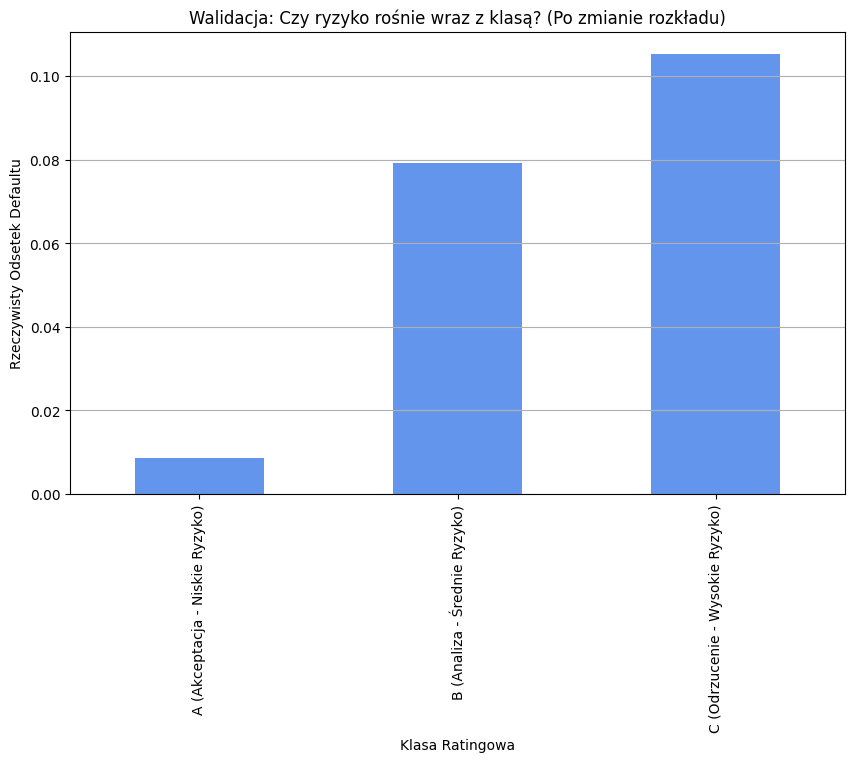

In [199]:
# rating_bins = [0.00, 0.045, 0.15, 1.01]

# rating_labels = [
#     "A (Akceptacja)", 
#     "B (Akceptacja lub analiza)", 
#     "C (Odrzucenie)"
# ]

# def pd_to_rating(p, bins, labels):
#     return pd.cut(p, bins=bins, labels=labels, right=False, include_lowest=True)


# final_pd = proba_iso_4pct

# ratings = pd_to_rating(final_pd, rating_bins, rating_labels)

# print("--- Liczność klientów w każdej klasie ratingowej ---")
# tab_licznosci = pd.crosstab(ratings, columns="Liczność klientów")
# print(tab_licznosci)


# validation_df = pd.DataFrame({
#     'Rating': ratings,
#     'Predicted_PD': final_pd,
#     'Actual_Default': y_test
# })

# rating_summary = validation_df.groupby('Rating').agg(
#     Liczność=('Rating', 'count'),
#     Średnie_Prognozowane_PD=('Predicted_PD', 'mean'),
#     Rzeczywisty_Odsetek_Default=('Actual_Default', 'mean')
# )

# print("\n--- Walidacja Monotoniczności Ratingów ---")
# print(rating_summary)

# plt.figure(figsize=(10, 6))
# rating_summary['Rzeczywisty_Odsetek_Default'].plot(kind='bar', color='salmon')
# plt.title("Walidacja: Rzeczywisty % Defaultu vs Klasa Ratingowa")
# plt.xlabel("Klasa Ratingowa")
# plt.ylabel("Rzeczywisty Odsetek Defaultu (im wyżej, tym gorzej)")
# plt.grid(axis='y')
# plt.show()

# decision_table = rating_summary[['Średnie_Prognozowane_PD', 'Rzeczywisty_Odsetek_Default']].copy()

# decision_table['Sugerowana Decyzja Biznesowa'] = [
#     "Akceptacja Automatyczna", 
#     "Odrzucenie (lub Analiza Manualna)",
#     "Odrzucenie Automatyczne"
# ]

# print("\n--- Finalna Tabela Decyzyjna / Mapa Ratingowa ---")

# decision_table['Średnie_Prognozowane_PD'] = decision_table['Średnie_Prognozowane_PD'].map('{:.2%}'.format)
# decision_table['Rzeczywisty_Odsetek_Default'] = decision_table['Rzeczywisty_Odsetek_Default'].map('{:.2%}'.format)

# print(decision_table.to_markdown(numalign="left", stralign="left"))




# NOWA WERSJA ------------------------------------------------------------------------------------------------------------------



threshold_A = np.quantile(final_pd, 0.33)
threshold_B = np.quantile(final_pd, 0.67)

if threshold_A < 0.0001:
    threshold_A = np.quantile(final_pd, 0.05)

print(f"Nowy próg dla Klasy A (PD < ...): {threshold_A:.4f}")
print(f"Nowy próg dla Klasy B (PD < ...): {threshold_B:.4f}")

rating_bins = [0.00, threshold_A, threshold_B, 1.01]
rating_labels = [
    "A (Akceptacja - Niskie Ryzyko)", 
    "B (Analiza - Średnie Ryzyko)", 
    "C (Odrzucenie - Wysokie Ryzyko)"
]

def pd_to_rating(p, bins, labels):
    return pd.cut(p, bins=bins, labels=labels, right=False, include_lowest=True)

ratings = pd_to_rating(final_pd, rating_bins, rating_labels)

print("\n--- Nowa liczność klientów (Dążymy do rozkładu 25/50/25) ---")
tab_licznosci = pd.crosstab(ratings, columns="Liczność klientów")
print(tab_licznosci)

validation_df = pd.DataFrame({
    'Rating': ratings,
    'Predicted_PD': final_pd,
    'Actual_Default': y_test
})

rating_summary = validation_df.groupby('Rating').agg(
    Liczność=('Rating', 'count'),
    Średnie_Prognozowane_PD=('Predicted_PD', 'mean'),
    Rzeczywisty_Odsetek_Default=('Actual_Default', 'mean')
)

print("\n--- Walidacja Monotoniczności Ratingów ---")
print(rating_summary)

plt.figure(figsize=(10, 6))
rating_summary['Rzeczywisty_Odsetek_Default'].plot(kind='bar', color='cornflowerblue')
plt.title("Walidacja: Czy ryzyko rośnie wraz z klasą? (Po zmianie rozkładu)")
plt.xlabel("Klasa Ratingowa")
plt.ylabel("Rzeczywisty Odsetek Defaultu")
plt.grid(axis='y')
plt.show()